In [1]:
import warnings
warnings.filterwarnings('ignore') # to avoid warnings

import random
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import json
import re
import os

"""
Sklearn Libraries
"""
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

"""
Transformer Libraries
"""
# from transformers import BertTokenizer,  AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

"""
Pytorch Libraries
"""
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [2]:
# # set period under observation
# start_date = datetime(2023, 1, 1)
# end_date = datetime.today() - relativedelta(months=2)

# # Iterate through 1st of each month
# data = []
# current_date = start_date
# while current_date < end_date:
#     f_name = f'Tweets/tweets_{current_date.strftime('%b%y').lower()}.json'
#     with open(f_name, "r") as file:
#         temp = json.loads(file.read())
#         temp = [json.loads(tweet) for tweet in temp]
#     data.extend(temp)
#     # Increment to the 1st of the next month
#     current_date += relativedelta(months=+1)

In [2]:
directory_path = 'Tweets/'
directory = os.fsencode(directory_path)

In [3]:
data = []
for file in os.listdir(directory):
    fname = os.fsdecode(file)
    if fname.endswith(".json"): 
        with open(f'{directory_path}{fname}', "r") as file:
            temp = json.loads(file.read())
            temp = [json.loads(tweet) for tweet in temp]
        data.extend(temp)

In [4]:
# Convert list of tweets into a dataframe
tweets_df = pd.DataFrame(data)

# Keep only relevant columns
cols_to_keep = ['id', 'date', 'user', 'lang', 'rawContent']
tweets_df = tweets_df.loc[:, cols_to_keep]

tweets_user_df = pd.DataFrame(tweets_df['user'].tolist())
tweets_user_df.rename(columns={'id': 'user_id'}, inplace=True)

user_cols_keep = ['user_id', 'username', 'displayname', 'rawDescription']
tweets_user_df = tweets_user_df.loc[:, user_cols_keep]

# Concatenating the original DataFrame with the passages dataframe
tweets_df = pd.concat([tweets_df, tweets_user_df], axis=1)
tweets_df.drop(columns='user', inplace=True)

# Convert date to yyyy-mm-dd format
tweets_df['date'] = pd.to_datetime(tweets_df['date']).dt.strftime('%Y-%m-%d')

#Keep only tweets in english
tweets_df = tweets_df[tweets_df['lang'] == 'en']

tweets_df.drop_duplicates(inplace=True)
tweets_df.reset_index(inplace=True, drop=True)
tweets_df.head()

,id,date,lang,rawContent,user_id,username,displayname,rawDescription
0,1785820420652085579,2024-05-01,en,"TD on Cenovus Energy's 1Q24 Conference Call\n""...",1213673551305199620,emmpeethree,The Napster,"Focusing on energy investing, #FIRE, churning ..."
1,1785676648953831445,2024-05-01,en,"DJ and TD on Cenovus Energy's 1Q24 \n""1Q24 fir...",1213673551305199620,emmpeethree,The Napster,"Focusing on energy investing, #FIRE, churning ..."
2,1785816061457358941,2024-05-01,en,"🚩Crude Oil -2.97%, with interest rates remaini...",1754316103852204032,ForeverRebate,Forever Rebate,"I have traded FX, Futures, and Stocks for over..."
3,1785814624455332253,2024-05-01,en,DJ on Imperial Oil's 1Q24 (Full report)\n“‘I’m...,1213673551305199620,emmpeethree,The Napster,"Focusing on energy investing, #FIRE, churning ..."
4,1785391289539973283,2024-04-30,en,"TD on Imperial Oil's 1Q24 Conference Call\n""Q1...",1213673551305199620,emmpeethree,The Napster,"Focusing on energy investing, #FIRE, churning ..."


In [5]:
remove_line = lambda x: re.sub('\n', '', x)
remove_handles = lambda x: re.sub(r'@[^\s]+','',x)
remove_urls = lambda x: re.sub(r'https?://\S+|www\.\S+','', x)
# remove_hashtags = lambda x: re.sub(r'#\S+', '', x)
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001F4A0-\U0001F4AF"  # additional emoticons
                           u"\U0001F525"             # flame
                           u"\U0001F929"             # star-struck
                           "]+", flags=re.UNICODE)
remove_emojis = lambda x: emoji_pattern.sub(r'', x) # no emoji

# stop_words_nltk = set(stopwords.words('english'))
# tokenizer = TweetTokenizer()
# lemmatizer = WordNetLemmatizer()

def preprocess_tweet(tweet):
    """
    Clean tweet content (removal of hanles, urls, hashtags and new line indicators)
    Tokenize and Lemmatize tweet contents
        Args:
        - tweet: tweet of type String
        Returns:
        - processed_tweets: A list of preprocessed tokens of type String.
    """
    tweeet_clean = tweet
    for func in (remove_line, remove_handles, remove_urls, remove_emojis):
        tweeet_clean = func(tweeet_clean)
    # processed_tweets = [w for w in tokenizer.tokenize(tweeet_clean) if (w not in stop_words_nltk)]
    # processed_tweets = [lemmatizer.lemmatize(w) for w in processed_tweets if len(w) > 2]    
    return tweeet_clean

tweets_df['rawContent'] = tweets_df['rawContent'].apply(preprocess_tweet)
# tweets_df['rawDescription'] = tweets_df['rawDescription'].apply(preprocess_tweet)
tweets_df.drop_duplicates('rawContent', inplace=True)
tweets_df.reset_index(inplace=True, drop=True)
tweets_df.head()

,id,date,lang,rawContent,user_id,username,displayname,rawDescription
0,1785820420652085579,2024-05-01,en,"TD on Cenovus Energy's 1Q24 Conference Call""Q1...",1213673551305199620,emmpeethree,The Napster,"Focusing on energy investing, #FIRE, churning ..."
1,1785676648953831445,2024-05-01,en,"DJ and TD on Cenovus Energy's 1Q24 ""1Q24 first...",1213673551305199620,emmpeethree,The Napster,"Focusing on energy investing, #FIRE, churning ..."
2,1785816061457358941,2024-05-01,en,"Crude Oil -2.97%, with interest rates remainin...",1754316103852204032,ForeverRebate,Forever Rebate,"I have traded FX, Futures, and Stocks for over..."
3,1785814624455332253,2024-05-01,en,DJ on Imperial Oil's 1Q24 (Full report)“‘I’m t...,1213673551305199620,emmpeethree,The Napster,"Focusing on energy investing, #FIRE, churning ..."
4,1785391289539973283,2024-04-30,en,"TD on Imperial Oil's 1Q24 Conference Call""Q1/2...",1213673551305199620,emmpeethree,The Napster,"Focusing on energy investing, #FIRE, churning ..."


In [7]:
tweets_df = tweets_df[tweets_df['rawContent'].apply(lambda x: len(x) <= 512)]
tweets_df.reset_index(drop=True, inplace=True)

In [13]:
# Load FinBERT model and tokenizer
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# sentiment_analyzer = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [14]:
from transformers import TextClassificationPipeline

class sentimentClassifier(TextClassificationPipeline):
    def postprocess(self, model_outputs):
        outputs = model_outputs["logits"]
        predictions = torch.nn.functional.softmax(outputs, dim=-1).reshape((-1,))
        return predictions.tolist()

sentiment_analyzer = sentimentClassifier(model=model, tokenizer=tokenizer)

In [15]:
for index, row in tqdm(tweets_df.iterrows(), total=tweets_df.shape[0], desc="Processing rows"):
    result = sentiment_analyzer(row['rawContent'])
    tweets_df.at[index, 'Positive'], tweets_df.at[index, 'Negative'], tweets_df.at[index, 'Neutral'] = zip(*result)
    # result = sentiment_analyzer(row['rawContent'])
    # tweets_df.at[index, 'label'] = 0 if result['label'] == 'neutral' else (1 if result['label'] == 'positive' else -1)
    # tweets_df.at[index, 'score'] = result['score']

# tweets_df['adjusted_score'] = tweets_df['label'] * tweets_df['score']   
tweets_df.head()

Processing rows: 100%|██████████| 15478/15478 [11:59<00:00, 21.50it/s]


,id,date,lang,rawContent,user_id,username,displayname,rawDescription,Positive,Negative,Neutral
0,1785820420652085579,2024-05-01,en,"TD on Cenovus Energy's 1Q24 Conference Call""Q1...",1213673551305199620,emmpeethree,The Napster,"Focusing on energy investing, #FIRE, churning ...",0.031272,0.030579,0.938149
1,1785676648953831445,2024-05-01,en,"DJ and TD on Cenovus Energy's 1Q24 ""1Q24 first...",1213673551305199620,emmpeethree,The Napster,"Focusing on energy investing, #FIRE, churning ...",0.936284,0.015765,0.047951
2,1785816061457358941,2024-05-01,en,"Crude Oil -2.97%, with interest rates remainin...",1754316103852204032,ForeverRebate,Forever Rebate,"I have traded FX, Futures, and Stocks for over...",0.108857,0.109851,0.781292
3,1785814624455332253,2024-05-01,en,DJ on Imperial Oil's 1Q24 (Full report)“‘I’m t...,1213673551305199620,emmpeethree,The Napster,"Focusing on energy investing, #FIRE, churning ...",0.038478,0.020778,0.940744
4,1785391289539973283,2024-04-30,en,"TD on Imperial Oil's 1Q24 Conference Call""Q1/2...",1213673551305199620,emmpeethree,The Napster,"Focusing on energy investing, #FIRE, churning ...",0.900378,0.014661,0.084961


In [16]:
tweets_df.to_csv('tweets_sentiment.csv')

In [2]:
# # Get the FinBERT Tokenizer
# finbert_tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert", 
#                                           do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

Encoding in progress...


100%|██████████| 3926/3926 [00:00<00:00, 4376.19it/s]


End of Task.
Maximum Sequence Length is 97


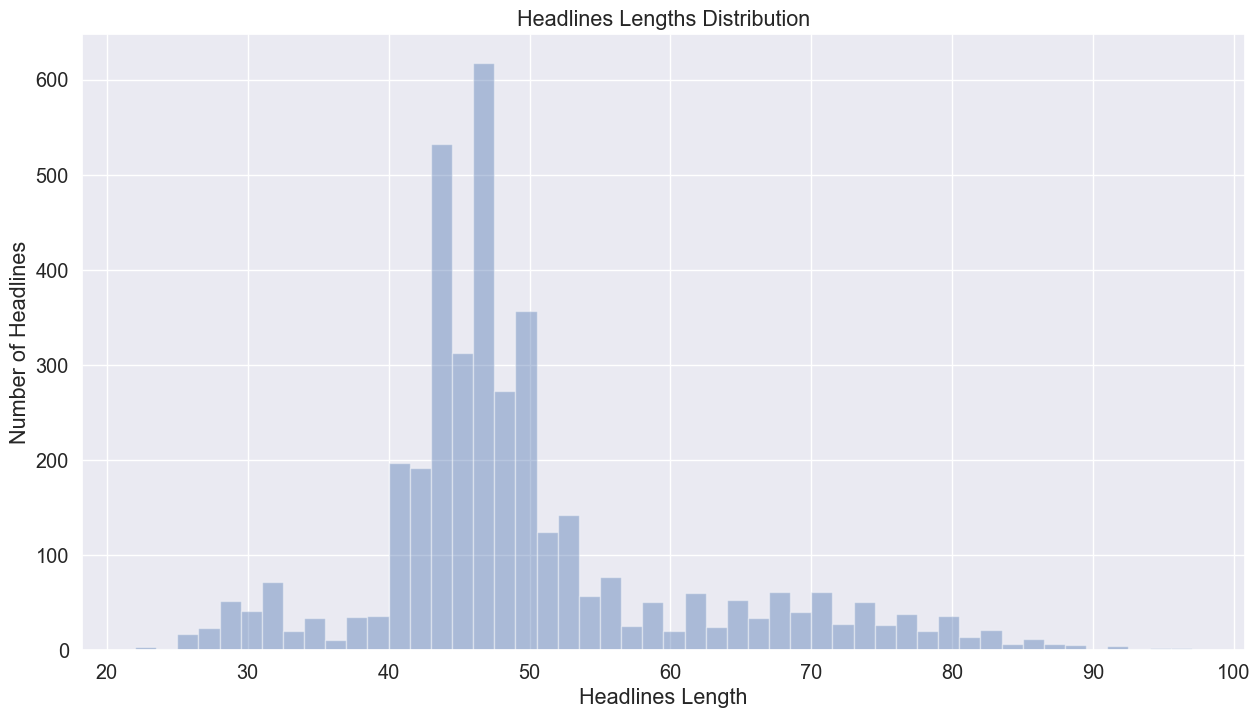

In [18]:
# def get_content_len(df):
    
#     headlines_sequence_lengths = []
    
#     print("Encoding in progress...")
#     for content in tqdm(df.rawContent):
#         encoded_content = finbert_tokenizer.encode(content, 
#                                          add_special_tokens = True)
        
#         # record the length of the encoded review
#         headlines_sequence_lengths.append(len(encoded_content))
#     print("End of Task.")
    
#     return headlines_sequence_lengths

# def show_content_distribution(sequence_lengths, figsize = (15,8)):
    
#     # Get the percentage of reviews with length > 512
#     len_512_plus = [rev_len for rev_len in sequence_lengths if rev_len > 512]
#     percent = (len(len_512_plus)/len(sequence_lengths))*100
    
#     print("Maximum Sequence Length is {}".format(max(sequence_lengths)))
    
#     # Configure the plot size
#     plt.figure(figsize = figsize)

#     sns.set(style='darkgrid')
    
#     # Increase information on the figure
#     sns.set(font_scale=1.3)
    
#     # Plot the result
#     sns.distplot(sequence_lengths, kde = False, rug = False)
#     plt.title('Headlines Lengths Distribution')
#     plt.xlabel('Headlines Length')
#     plt.ylabel('Number of Headlines')

# headlines_sequence_lengths = get_content_len(tweets_df)
# show_content_distribution(headlines_sequence_lengths)

In [19]:
# # Encode the data
# encoded_data = finbert_tokenizer.batch_encode_plus(
#     tweets_df.rawContent.values, 
#     return_tensors='pt',
#     add_special_tokens=True, 
#     return_attention_mask=True, 
#     pad_to_max_length=True, 
#     max_length=97 # the maximum lenght observed in rawContent
# )

# # # Encode the Validation data
# # encoded_data_val = finbert_tokenizer.batch_encode_plus(
# #     financial_data[financial_data.data_type=='val'].NewsHeadline.values, 
# #     return_tensors='pt',
# #     add_special_tokens=True, 
# #     return_attention_mask=True, 
# #     pad_to_max_length=True, 
# #     max_length=150 # the maximum lenght observed in the headlines
# # )


# # input_ids_train = encoded_data_train['input_ids']
# # attention_masks_train = encoded_data_train['attention_mask']
# # labels_train = torch.tensor(financial_data[financial_data.data_type=='train'].label.values)

# # input_ids_val = encoded_data_val['input_ids']
# # attention_masks_val = encoded_data_val['attention_mask']
# # sentiments_val = torch.tensor(financial_data[financial_data.data_type=='val'].label.values)


# # dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
# # dataset_val = TensorDataset(input_ids_val, attention_masks_val, sentiments_val)

# encoded_data

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'input_ids': tensor([[  101,  2634, 13275,  ...,     0,     0,     0],
        [  101,  2634, 13275,  ...,     0,     0,     0],
        [  101,  6084,  1041,  ...,     0,     0,     0],
        ...,
        [  101,  1037,  3722,  ...,     0,     0,     0],
        [  101,  5712, 18989,  ...,     0,     0,     0],
        [  101,  2013,  1030,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}